In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

sns.set_style('whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/Takashi/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
positive_count_train = train['target'].sum()

In [4]:
rus = RandomUnderSampler(ratio={0:positive_count_train*3, 1:positive_count_train}, random_state=0)
X_train_resampled, y_train_resampled = rus.fit_sample(train[train.columns[2:]], train['target'])

In [5]:
features = train.columns[2:]
y_train_df = pd.DataFrame(y_train_resampled, columns=['target'])
train = pd.DataFrame(X_train_resampled, columns=features)

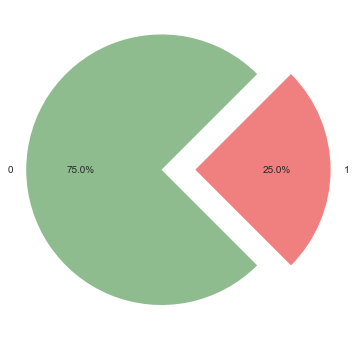

In [6]:
colors = ['darkseagreen','lightcoral']
plt.figure(figsize=(6,6))
plt.pie(y_train_df['target'].value_counts(), explode=(0, 0.25), labels= ["0", "1"],
        startangle=45, autopct='%1.1f%%', colors=colors)
plt.axis('equal')
plt.show()

In [7]:
target = y_train_df['target']

In [8]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [9]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = features
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.904652	valid_1's auc: 0.885796
[2000]	training's auc: 0.916053	valid_1's auc: 0.892125
[3000]	training's auc: 0.924337	valid_1's auc: 0.894977
[4000]	training's auc: 0.930776	valid_1's auc: 0.896495
[5000]	training's auc: 0.936434	valid_1's auc: 0.897293
[6000]	training's auc: 0.94146	valid_1's auc: 0.897945
[7000]	training's auc: 0.946222	valid_1's auc: 0.898256
[8000]	training's auc: 0.9507	valid_1's auc: 0.898012
[9000]	training's auc: 0.954924	valid_1's auc: 0.898048
[10000]	training's auc: 0.958937	valid_1's auc: 0.89786
Early stopping, best iteration is:
[7044]	training's auc: 0.94644	valid_1's auc: 0.898322
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.904197	valid_1's auc: 0.888201
[2000]	training's auc: 0.915769	valid_1's auc: 0.895016
[3000]	training's auc: 0.923964	valid_1's auc: 0.898693
[4000]	training's auc: 0.930392	valid_1's a

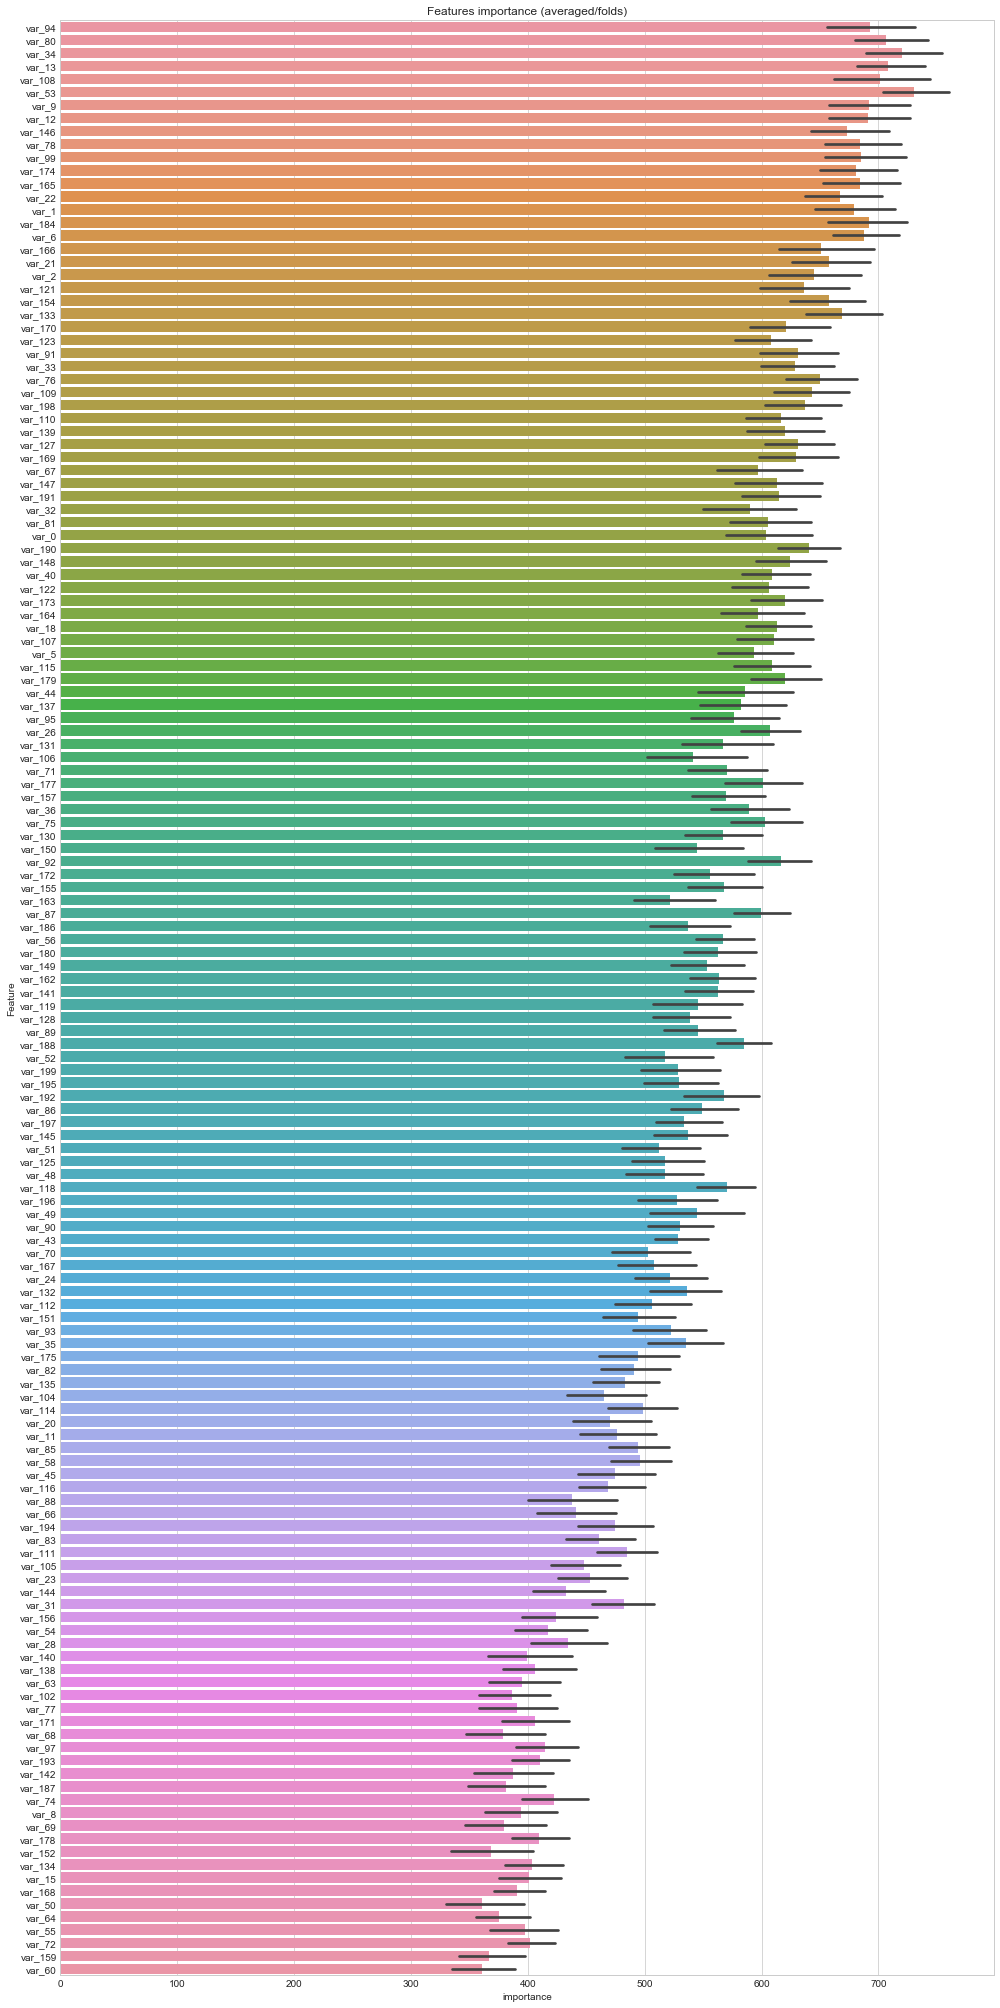

In [10]:
cols = (feature_importance[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance.loc[feature_importance.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [ ]:
score = round(roc_auc_score(target, oof), 4)
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"]=predictions
sub.to_csv(f"submission_{score}.csv", index=False)